In [12]:
from pathlib import Path
import numpy as np
import datetime
import json
import os
import pandas as pd
import rasterio
import skimage.io as skio
from PIL import Image
from cropmask.coco_convert import split_save_train_validation_test_df, save_coco_annotation, create_coco_dataset
from cropmask.misc import parse_yaml, make_dirs

from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.
from detectron2.data.datasets import register_coco_instances, load_coco_json

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import cv2
import random
from skimage.io import imshow, imread
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor, launch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from cropmask.misc import max_normalize, percentile_rescale
from cropmask.detectron2_cropmask_cfg import cfg
from cropmask import detectron2_reclass # fair amount of stuff goes on in here to make detectron work for this project.

tiles_path = Path(cfg.DATASET_PATH) / "tiles"
train, validation, test = split_save_train_validation_test_df(tiles_path, save_empty_tiles=False)
coco_path = Path(cfg.DATASET_PATH) / "coco"

def read_and_mean(path):
    arr = skio.imread(path)
    fill_values = np.mean(arr, axis=(0, 1))
    return fill_values
    
def read_and_variance(path):
    arr = skio.imread(path)
    fill_values = np.var(arr, axis=(0, 1))
    return fill_values

def calc_stat(df, func, include_empty=False):
    """
    func should operate on a single array of order [band, H, W]
    """
    df = df.copy()
    new_df = df[df.is_empty == include_empty]
    new_df['fill_values'] = new_df['jpeg_tiles'].apply(func)
    new_df = pd.DataFrame(new_df.fill_values.tolist(), columns=['0', '1', '2'])
    return new_df

def max_norm_channels(arr):
    """
    arr must be of shape (w, h, channel)
    """
    arr = arr.copy()
    maxes = np.nanmax(arr, axis=(0,1))
    return arr / maxes

def make_vis_im(img):
    img = img[:, :, ::-1]
    normalized = max_norm_channels(np.where(img < 0, 0, img))
    rescaled = rescale_intensity(normalized, out_range=(0,255))
    masked = np.where(rescaled==0, np.nan, rescaled)
    return masked

mean_df = calc_stat(train, read_and_mean)
var_df = calc_stat(train, read_and_variance)

channel_means = mean_df.mean(axis=0).values
channel_stds = np.sqrt(var_df.mean(axis=0).values)

train_coco_instances_path = str(coco_path / "instances_train.json")
val_coco_instances_path = str(coco_path / "instances_val.json")
test_coco_instances_path = str(coco_path / "instances_test.json")

In [13]:
def switch_tif_jpeg(tif_json):
    json_jpeg = []
    for i in tif_json:
        i['file_name'] = i['file_name'].replace(".tif", ".jpg") 
        json_jpeg.append(i)
    return json_jpeg

In [14]:
if (coco_path / "instances_train.json").exists() is False:
    train_coco_dict = create_coco_dataset(train)
    val_coco_dict = create_coco_dataset(validation)
    test_coco_dict = create_coco_dataset(test)
    save_coco_annotation(train_coco_instances_path, train_coco_dict)
    save_coco_annotation(val_coco_instances_path, val_coco_dict)
    save_coco_annotation(test_coco_instances_path, test_coco_dict)
# register each val and test set if there are more than one.
register_coco_instances(cfg.DATASETS.TRAIN[0], {}, train_coco_instances_path, str(next(tiles_path.glob("*jpeg*"))))
register_coco_instances(cfg.DATASETS.VALIDATION[0], {}, val_coco_instances_path, str(next(tiles_path.glob("*jpeg*"))))
register_coco_instances(cfg.DATASETS.TEST[0], {}, test_coco_instances_path, str(next(tiles_path.glob("*jpeg*"))))

train_json = switch_tif_jpeg(load_coco_json(train_coco_instances_path,  str(next(tiles_path.glob("*jpeg*")))))
val_json = switch_tif_jpeg(load_coco_json(val_coco_instances_path,  str(next(tiles_path.glob("*jpeg*")))))
test_json = switch_tif_jpeg(load_coco_json(test_coco_instances_path,  str(next(tiles_path.glob("*jpeg*")))))
try:
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=False)
except:
    pass

100%|██████████| 3/3 [00:00<00:00, 30.26it/s]


instances_train.json saved.
instances_val.json saved.
instances_test.json saved.


AssertionError: Dataset 'train' is already registered!

In [15]:
print(channel_means)
print(channel_stds)

[ 31.31802877  54.00640912 142.37234412]
[26.77188394 39.38982682 67.98077771]


(array([2.5520e+03, 7.7850e+03, 1.4686e+04, 6.6522e+04, 9.9693e+04,
        9.9901e+04, 9.8965e+04, 5.9358e+04, 5.3166e+04, 4.6229e+04,
        4.9864e+04, 5.0042e+04, 4.0971e+04, 2.2767e+04, 1.3903e+04,
        1.0801e+04, 9.8450e+03, 1.0715e+04, 7.7260e+03, 5.1480e+03,
        2.9990e+03, 2.6580e+03, 1.6590e+03, 9.6600e+02, 8.9200e+02,
        8.5200e+02, 7.9500e+02, 8.3100e+02, 8.2500e+02, 9.5700e+02,
        9.2000e+02, 6.1500e+02, 5.1000e+02, 2.9200e+02, 2.2000e+01]),
 array([ 279.        ,  434.14285714,  589.28571429,  744.42857143,
         899.57142857, 1054.71428571, 1209.85714286, 1365.        ,
        1520.14285714, 1675.28571429, 1830.42857143, 1985.57142857,
        2140.71428571, 2295.85714286, 2451.        , 2606.14285714,
        2761.28571429, 2916.42857143, 3071.57142857, 3226.71428571,
        3381.85714286, 3537.        , 3692.14285714, 3847.28571429,
        4002.42857143, 4157.57142857, 4312.71428571, 4467.85714286,
        4623.        , 4778.14285714, 4933.285

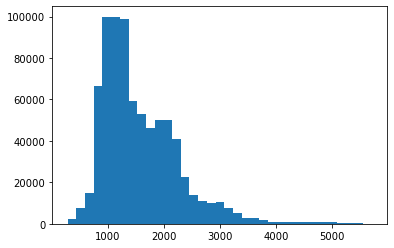

In [16]:
import matplotlib.pyplot as plt

plt.hist(skio.imread(train['image_tiles'].iloc[1]).flatten(), bins=35)

### Printing Truth Labels and Images

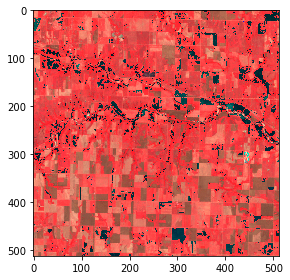

In [11]:
skio.imshow(img)

In [17]:
for d in random.sample(train_json, 1):
    if len(d['annotations']) > 0:
        img = imread(d["file_name"])
        img = img[:, :, ::-1]
        normalized = max_norm_channels(np.where(img < 0, 0, img))
        rescaled = rescale_intensity(normalized, out_range=(0,255))
        masked = np.where(rescaled==0, np.nan, rescaled)
        visualizer = Visualizer(rescaled, metadata={}, scale=0.5)
        vis = visualizer.draw_dataset_dict(d)
        plt.figure(figsize = (8,16))
        imshow(vis.get_image())

FileNotFoundError: No such file: '/datadrive/test-ard-june-sept-nirrg-jpeg-fill0/tiles/jpeg_tiles/LT05_CU_014008_20050805_20181227_C01_V0_-404145_2072325.jpg'

# Model Inspection

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0002399.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(train_json, 1):    
    im = imread(d["file_name"])
    outputs = predictor(im)
    vis_im = make_vis_im(im)
    visualizer_preds = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    visualizer_labels = Visualizer(vis_im,
                   scale=1, 
                   metadata= {}   # remove the colors of unsegmented pixels
    )
    v = visualizer_preds.draw_instance_predictions(outputs["instances"].to("cpu"))
    labels = visualizer_labels.draw_dataset_dict(d)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,16))
    imshow(v.get_image(), ax=ax[0])
    imshow(labels.get_image(), ax=ax[1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test", cfg, False, output_dir="/datadrive/evaluator_output/")
test_loader = build_detection_test_loader(cfg, "test")

In [ ]:
inference_on_dataset(predictor.model, test_loader, evaluator)
# another equivalent way is to use trainer.test